# Codes 3 – Ensemble Learning

If you aggregate the predictions of a group of predictors (such as
classifiers or regressors), you will often get better predictions than with the best
individual predictor. A group of predictors is called an ensemble; thus, this
technique is called Ensemble Learning, and an Ensemble Learning algorithm is
called an Ensemble method.

We will discuss the most popular Ensemble methods, including
bagging, boosting, and a few others. We will explore in particular the so-called Random
Forest algorithm.

<font color=red> Note 1

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensemble_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Figures", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting classifiers

To illustrate the trick behind ensemble methods (for classification), let us throw a coin slightly biased with $P(head)=0.51$ and $P(tail=0.49)$.

We represent on a graph the proportion of heads when tossing the coin 1 times,
                                                             10 times,
                                                             1000 times,
                                                             ...
The proportion converges to the probability to have a head (law of large numbers), which is of 0.51.

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 1) < heads_proba).astype(np.int32) # 1 with Proba 0.51, and 0 otherwise. ou np.random.rand(10000, 1)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


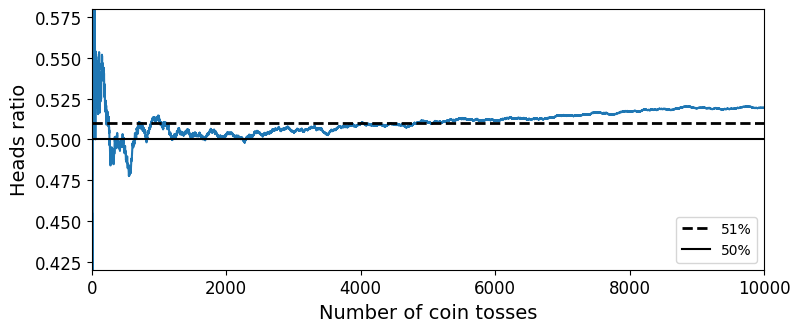

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

On the graph, you can find the empirical mean of 1 (head) and 0 (tail) for a number of draws 1,10,100,2000,4000, etc. The empirical mean is more and more stable around 0.51, which is the probability of having a head (illustration of the law of large numbers).

It is the same idea for ensemble methods: The predictions will be more and more stable by aggregating the predictions issued from a large number of classifiers. The average prediction will be of 51% with 10000 classifiers, which is the probability that $y=1$ which corresponds to the probability we ultimately want to predict!

<font color=red> Note 2

The following code creates and trains a voting classifier in Scikit-Learn,
composed of three diverse classifiers (the training set is the moons dataset):

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
# Default value => 75% for the training set and 25% for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

We set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions. To make that code stable across Python versions.

Let’s look at each classifier’s accuracy on the test set:

In [5]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

We condider 3 weak learners (3 classifiers), namely a SVM with a Gaussian RBF, a random forest, and a logistic regression. We aggregate the predictions of the classifiers following the hard voting classifier `voting='hard'`. There is a distinction with `voting="soft"`.

<font color=red> Note 3

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


There you have it! The voting classifier slightly outperforms all the individual
classifiers.

Let's now consider the soft voting rule:

In [8]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
# There is a way even for SVM classification to output class probability but you need to add the option 
# probability=True
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

# Don't forget to change the option by voting='soft'
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


The soft voting rule increases even more the accuracy of the ensemble method. You should favor it as a general recommendation when it is available.

# Bagging ensembles

One way to benefit of aggregation is to use very different training
algorithms, as just discussed. Another approach is to use the same training
algorithm for every predictor, but to train them on different random subsets of
the training set. When sampling is performed with replacement, this method is
called bagging (short terminology for "bootstrap aggregating"). When sampling is performed
without replacement, it is called pasting.

<font color=red> Note 4

The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100
training instances randomly sampled from the training set with replacement (this
is an example of bagging):

In [11]:
from sklearn.ensemble import BaggingClassifier # or BaggingRegressor
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42, n_jobs=1) #Bootstrap=TRUE => avec remise
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Trees classifiers.

<font color=red> Note 5

In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


We got an accuracy (percentage of correctly classified instances) of 90.4% on the test set. Note that the number of instances used for each classifier can be tuned using cross validation to increase even more the accuracy.

In [13]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


With a single tree, the accuracy reduces to 85.6% once again demonstrating the power of ensemble prediction.

In [14]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


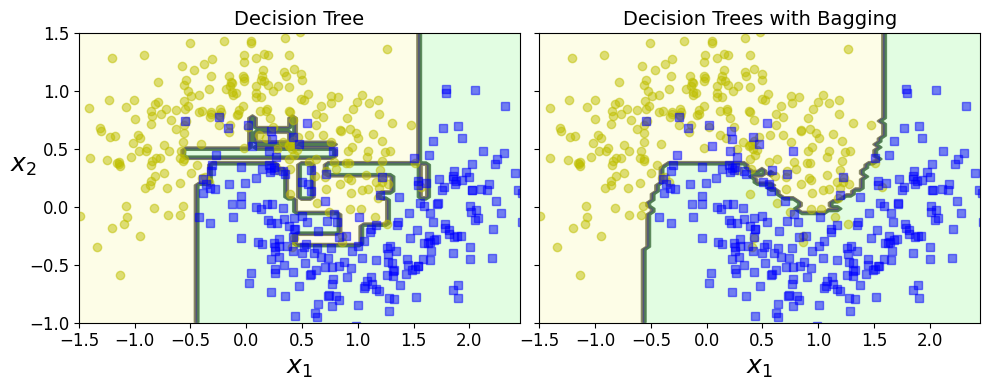

In [15]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

Decision boundary of a single Decision Tree (on the left) against decision boundary of a bagging ensemble of 500 trees (on the right from the preceding code).

The ensemble’s predictions will likely generalize much better than the single Decision Tree’s
predictions: 
the ensemble has a smaller variance (less irregular decision boundary) thanks to the power of aggregation.

## Out-of-Bag evaluation

<font color=red> Note 6

You can set oob_score=True when creating a
BaggingClassifier to request an automatic out-of-bag (oob) evaluation after training. The
following code demonstrates this. The resulting evaluation score is available
through the oob_score_ variable:

In [16]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

0.896 represents the average oob accuracy calculated on the whole 500 predictors, no need of a test set!

According to this oob evaluation, this BaggingClassifier is likely to achieve
about 89.6% accuracy on the test set. Let’s verify this:

In [18]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

We get 90.4% accuracy on the test set — close enough!

The oob decision function for each training instance is also available through the
`oob_decision_function_` variable. In this case (since the base estimator has a
predict_proba() method) the decision function returns the class probabilities
for each training instance. For example, the oob evaluation estimates that the
second training instance has a 35.65% probability of belonging to the positive
class (and 64.37% of belonging to the negative class)

In [19]:
bag_clf.oob_decision_function_

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97927461, 0.02072539],
       [0.75586854, 0.24413146],
       [0.0049505 , 0.9950495 ],
       [0.75520833, 0.24479167],
       [0.82122905, 0.17877095],
       [0.98461538, 0.01538462],
       [0.06315789, 0.93684211],
       [0.00490196, 0.99509804],
       [0.99004975, 0.00995025],
       [0.92513369, 0.07486631],
       [1.        , 0.        ],
       [0.03409091, 0.96590909],
       [0.35087719, 0.64912281],
       [0.91111111, 0.08888889],
       [1.        , 0.        ],
       [0.96319018, 0.03680982],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.6635514 , 0.3364486 ],
       [0.

# Random Forests

<font color=red> Note 7

Instead of building a BaggingClassifier and pasting it a DecisionTreeClassifier, you can instead
use the RandomForestClassifier class, which is more convenient and
optimized for Decision Trees (similarly, there is a RandomForestRegressor
class for regression tasks). 

The following code trains a Random Forest classifier
with 500 trees (each limited to maximum 16 nodes), using all available CPU
cores:

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [21]:
type(1.0)

float

In [22]:
1.0 * X_train.shape[0]

375.0

In [23]:
BaggingClassifier?

Init signature:
BaggingClassifier(
    base_estimator=None,
    n_estimators=10,
    *,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    oob_score=False,
    warm_start=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
)
Docstring:     
A Bagging classifier.

A Bagging classifier is an ensemble meta-estimator that fits base
classifiers each on random subsets of the original dataset and then
aggregate their individual predictions (either by voting or by averaging)
to form a final prediction. Such a meta-estimator can typically be used as
a way to reduce the variance of a black-box estimator (e.g., a decision
tree), by introducing randomization into its construction procedure and
then making an ensemble out of it.

This algorithm encompasses several works from the literature. When random
subsets of the dataset are drawn as random subsets of the samples, then
this algorithm is known as Pasting [1]_. If samples are drawn with
repl

The option `splitter="random"` is used to randomly select the feature to be split in the tree (default option is the usual way that identifies the best candidate feature using impurity measures `splitter="best"`). The typical Random Forest selects the feature to be split at random in each classifier.

In [24]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

In [26]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.912

In [27]:
RandomForestClassifier?

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.


In [28]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

Almost identical predictions between our home-made Random Forest algorithm using `BaggingClassifier` and the sklearn function `RandomForestClassifier`

<font color=red> Note 8

Let's train Extremely Randomized Trees (Extra-trees) which is a non regular Random Forest where the threshold for splitting trees is set at random.

In [29]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
extra_trees_clf.fit(X_train, y_train)

y_pred_extra_trees_clf = extra_trees_clf.predict(X_test)
accuracy_score(y_test, y_pred_extra_trees_clf)

0.912

## Feature importance

Random Forest is very useful to determine which features are the most important for the prediction task.

<font color=red> Note 9 <font color=black>

Scikit-Learn computes this automatically for every feature after training. You can access the result using the `feature_importances_` variable. 

The following code trains a RandomForestClassifier on
the iris dataset and outputs each feature’s importance.

In [30]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

Feature importance is normalized to 1 for ease of interpretation => Sum of the individual contribution is 1. 

In [31]:
np.sum(rnd_clf.feature_importances_)

1.0

In [32]:
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


It seems that the most important features are the petal length (contribution of 44%) and width
(contribution of 42%), while sepal length and width are rather unimportant in comparison (contribution of 11%
and 2%, respectively).

The following code trains a Random Forest classifier on the MNIST dataset and plot each pixel’s importance (representing our 784 features):

In [36]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist', version=1)
mnist.target = mnist.target.astype(np.uint8)
mnist.target

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/datasets/_openml.py:91: UserWarning: A network error occurred while downloading https://openml.org/api/v1/json/data/list/data_name/mnist/limit/2/data_version/1. Retrying...
  warn(


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)>

In [35]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

NameError: name 'mnist' is not defined

In [36]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


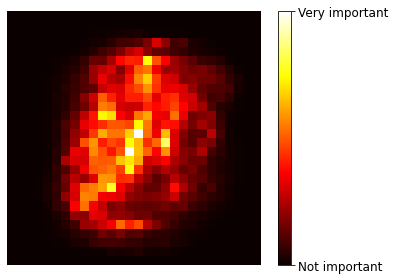

In [37]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

Random Forests are very handy to get a quick understanding of what features
actually matter, in particular if you need to perform feature selection.

# AdaBoost

The general idea of
most boosting methods is to train predictors sequentially, each trying to correct
its predecessor. There are many boosting methods available, but by far the most
popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting.
Let’s start with AdaBoost.

<font color=red> Note 10

The used command is `AdaBoostClassifier`. Here we set the learning rate $\eta=0.5$ and the number of iteration $T=10$. Base classifiers are simple decision trees. I consider very simple tree with only one node.

In [37]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=10,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=10, random_state=42)

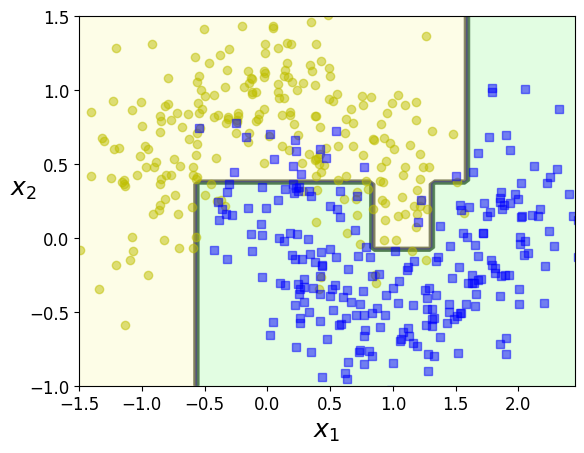

In [38]:
plot_decision_boundary(ada_clf, X, y)

The first AdaBoost gets many instances wrong: There are a lot of blue instances that are incorrectly classified. Let's try  to increase the number of iteration to $T=100$ to allow for aditional adjustement of the incorrectly classified prediction... 

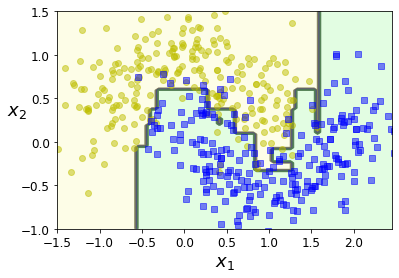

In [9]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
plot_decision_boundary(ada_clf, X, y)

The second classifier does a better job on these instances, and so on. The fit is much closer to the training instances: Increasing the number of iterations $T$ increase the fit of the training instances. Quite logic! 

BUT be aware that the AdaBoost ensemble method can easily overfit the training set. The final goal is having a good generalization on a test set. That's why, we generally fine-tune $T$ (and also sometimes $\eta$) via kfold cross validation to ensure a good generalization. Or we can also fine-tune the hyperparameters of the base learner as well (reducing the depth of the tree for instance if the base learner is a tree).

# Gradient Boosting

Gradient boosting is another boosting ensemble method

<font color=red> Note 11

Let’s go through a simple regression example using Regression Trees as the base
predictors. We consider a noisy quadratic training set:

In [39]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.005 * np.random.randn(100)

In [41]:
np.max(X)

0.4868869366005173

Text(0.5, 0, '$x_1$')

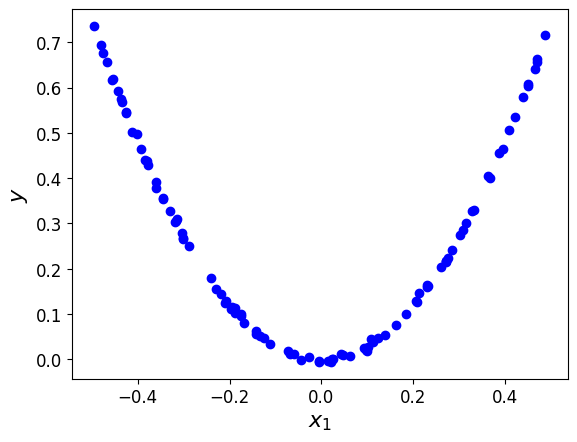

In [40]:
plt.plot(X, y,'bo')
plt.ylabel("$y$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

Let’s fit a DecisionTreeRegressor to the training set:

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Let's compute the prediction error $y2$. Then, train a second DecisionTreeRegressor on the residual errors $y2$ made by the first predictor:

In [44]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Let's compute the prediction error $y3$. Then we train a third regressor on the residual errors $y_3$:

In [45]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

We consider a new input $x=0.4$ and we are willing to make a predictions with our home-made gradient boosting algorithm:

In [46]:
X_new = np.array([[0.4]])

Now we have an ensemble containing three trees. It can make predictions on a
new instance simply by adding up the predictions of all the trees. We just sum the predictions issued from our three base learners as follows:

In [47]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [48]:
y_pred

array([0.46082615])

In [49]:
y_new = 3*X_new**2
y_new

array([[0.48]])

In [50]:
tree_reg1.predict(X_new)

array([0.55642987])

In [51]:
tree_reg2.predict(X_new)

array([0.04952728])

In [52]:
tree_reg3.predict(X_new)

array([-0.14513099])

In [59]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


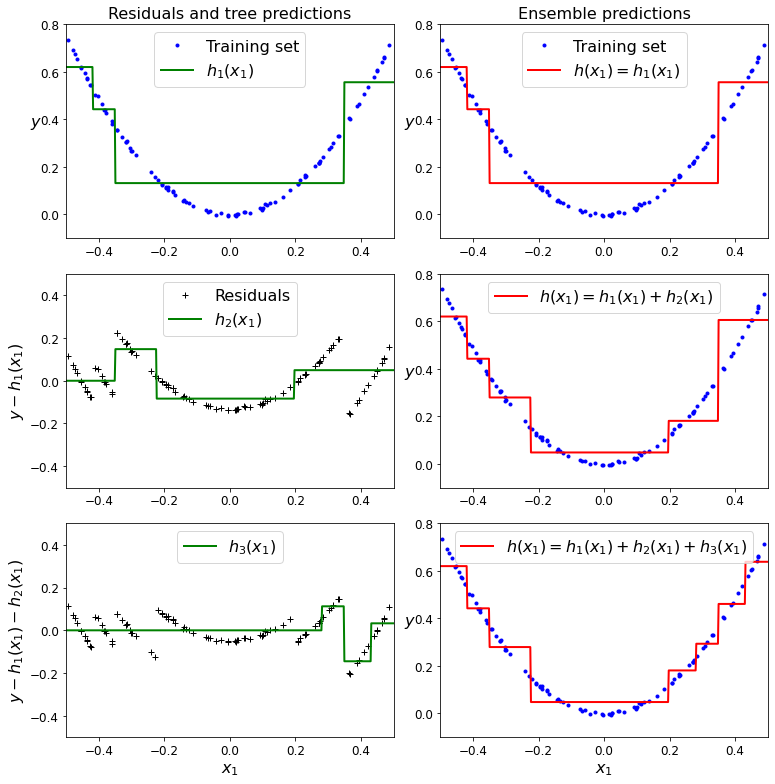

In [60]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

The figure represents the predictions of these three trees in the left column, and
the ensemble’s predictions in the right column. In the first row, the ensemble has
just one tree, so its predictions are exactly the same as the first tree’s predictions.
In the second row, a new tree is trained on the residual errors of the first tree. On
the right you can see that the ensemble’s predictions are equal to the sum of the
predictions of the first two trees. Similarly, in the third row another tree is
trained on the residual errors of the second tree. You can see that the ensemble’s
predictions gradually get better as trees are added to the ensemble.

A simpler way to train Gradient Boosting Regression tree ensembles is to use Scikit-Learn’s
`GradientBoostingRegressor` class. Similarly to the RandomForestRegressor
class, it has hyperparameters to control the growth of Decision Trees (e.g.,
max_depth, min_samples_leaf, and so on), as well as hyperparameters to
control the ensemble training (number of trees $T$ and learning rate $\eta$). The code creates the same ensemble as the previous one:

To reproduce the home-made boosting ensemble, we set $T=3$ (`n_estimators`=3) and we set the learning rate $\eta=1$ (`learning rate`=1). The learning rate $\eta$ is generally comprised between 0 and 1 (shrinkage parameter).

<font color=red> Note 12

In [57]:
print(y)

[[0.48]]


In [61]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

We consider now a Gradient Boosting model with a slower learning rate $\eta=0.1$ and alternately two competing number of trees $T=3$ against $T=200$.

In [62]:
gbrt_slowTsmall = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt_slowTsmall.fit(X, y)

gbrt_slowTlarge = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slowTlarge.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


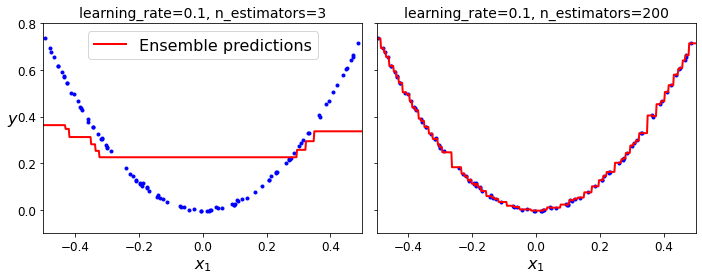

In [63]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt_slowTsmall], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slowTsmall.learning_rate, gbrt_slowTsmall.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slowTlarge], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slowTlarge.learning_rate, gbrt_slowTlarge.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

Here we have two Gradient Boosting ensembles with a slow learning rate $\eta=0.1$

- On the left, the ensemble does not have enough trees to fit the training set due to the slower rate.
- On the right, the ensemble has too many trees and overfits the training set (as a remainder the correct model is a quadratic function, the prediction in red is not enough smooth).

## Gradient Boosting with Early stopping

In order to find the optimal number of trees $T$, you can use early stopping. A simple way to implement this is to use the `staged_predict()` method: it returns an iterator over the predictions made by the ensemble at each
stage of training (with one tree, two trees, etc.). The following code trains a
GBRT ensemble with 120 trees, then measures the validation error at each stage
of training to find the optimal number of trees.

In [73]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [74]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the instances in a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

In [75]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# errors outputs the MSE of the Gradient Boosting for each tree's iteration t=1,...,120
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

In [76]:
len(errors)

120

In [77]:
min_error = np.min(errors)
min_error

0.002712853325235463

The lowest MSE computed on the validation sample is 0.0027...

In [78]:
bst_n_estimators = np.argmin(errors) + 1
bst_n_estimators

56

And is obtained for a number of trained trees $T=56$! So we have our optimal hyperparameter for the Gradient Boosting!

Finally we train the final ensemble learning using the optimal number of trees $T=56$.

In [79]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

Saving figure early_stopping_gbrt_plot


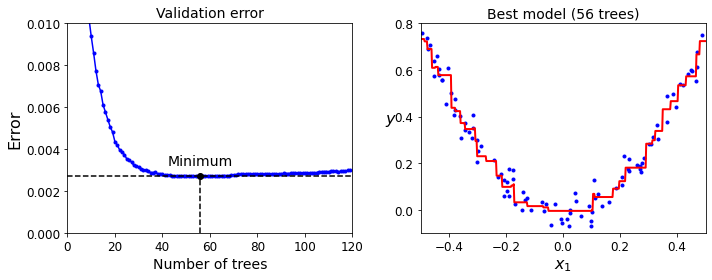

In [80]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

We plot on the left the MSE for various number of trees $T$. The minimum is reached for $T=56$ trees. Before $T=56$ there are
not enough trees and the model is underfitting the training set while beyond $T=56$ the model is too complex and is overfitting the training set. We observe a typical right-angled shape of the empirical risk curve.

On the right you can see the fit for the optimal number of trees on the entire dataset => Approximate properly the quatratic function.

Remark: It is possible to use Gradient Boosting with other cost functions (like the mean absolute error (LAD) for instance). This is controlled
by the loss hyperparameter
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
